## You Only Look Once: Unified, Real-Time Object Detection

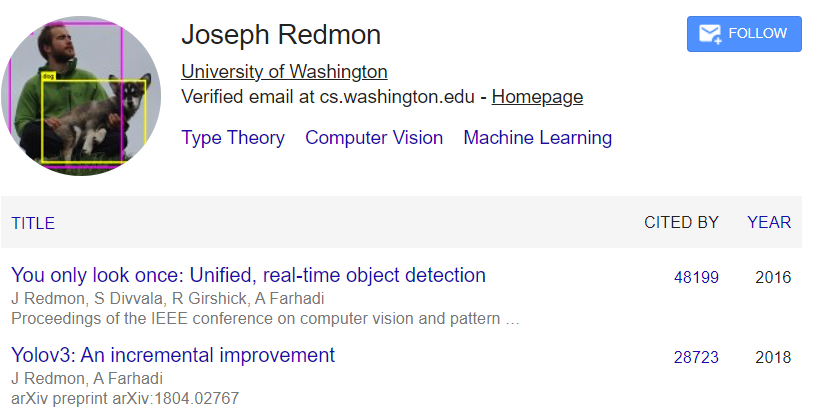

R-CNN 계열의 다른 object detection모델과는 다르게 Yolo는 1-stage detector개념을</br>
도입하여 한번의 두개의 Task를 진행한다

(기존의 R-CNN은 2-stage detector로 되어 있고, localization, classification</br>
2개의 task를 순차적으로 수행하게 설계되어 있음 -> 이를 Yolo는 1개, 병렬처리로 줄인거임)



### 논문의 기여
1. 초당 45프레임으로 object detection수행 가능
</br> -> 따라서 Real time detection이 가능함, 그리고 다른 네트워크 대비 mAP가 2배 높음

### 토막상식 : mAP(mean Average precision)

여기서 Precision은 아래의 표를 참조하자
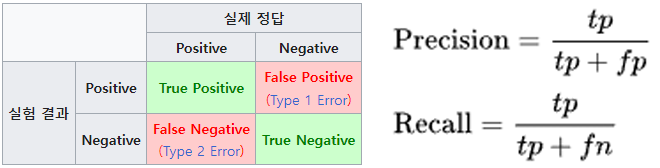

TP : True Positive - 검출 되어야할 것이 검출  - 긍정으로 예측한 값 중 실제 긍정인 값

FN : False Negative - 검출 되어야할 것이 검출 되지 않음  - 부정으로 예측한 값 중 실제 긍정인 값

FP : False Positive - 검출 되지 말아야할 것이 검출 - 긍정으로 예측한 값 중 실제 부정인 값

TN : True Negative - 검출 되지 말아야할 것이 검출 되지 않음 - 부정으로 예측한 값 중 실제 부정인 값



여기서 Obejction Detection에서 Precision을 구하려면 어떻게 해야 할까?

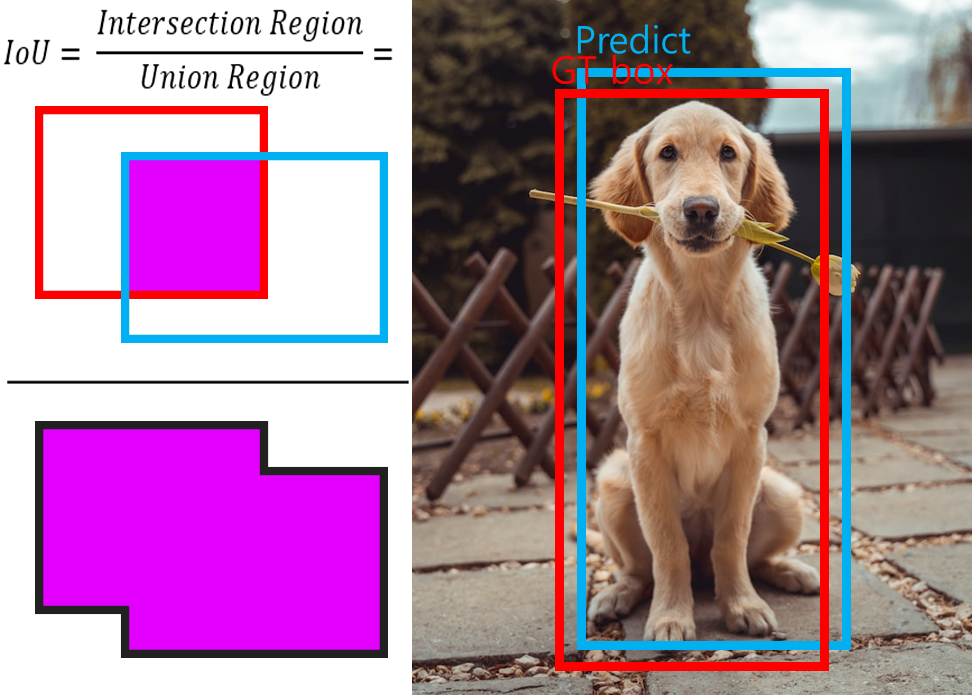

여기서 위 사진의 IoU(Intersection over Union)의 개념을 도입함

위 사진에서 IoU의 계산 결과가 0.5 이상이 된다 -> 재대로 검출(TP) 되었다 판단

2. 추론시 이미지를 전역적으로 파악함
</br> -> 기존 Objection Detection 방법론이 sliding window, region proposal을 
</br> 사용하는데 Yolo는 이미지의 전체를 바라봄</br>
</br> ---> 따라서 클래스의 맥락적 정보 + 모습(appearance)를 인코드 해서
</br> R-CNN보다 Background Error을 줄여냄

### sliding window 와 Region Proposal

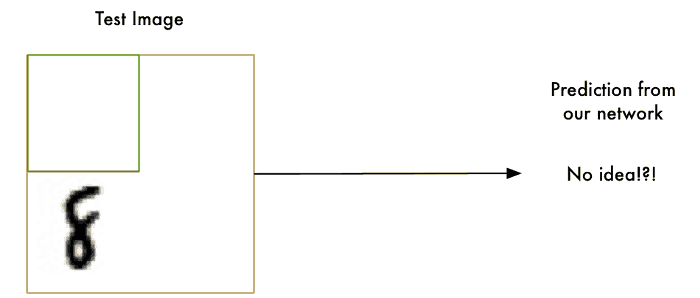

위 애니매이션처럼 ROI를 슬라이딩 시키는 것

Region Proposal : 주어진 이미지에서 물체가 있을 법한 위치를 찾는것
-> 이걸 가능하게 해주는 것이 R-CNN

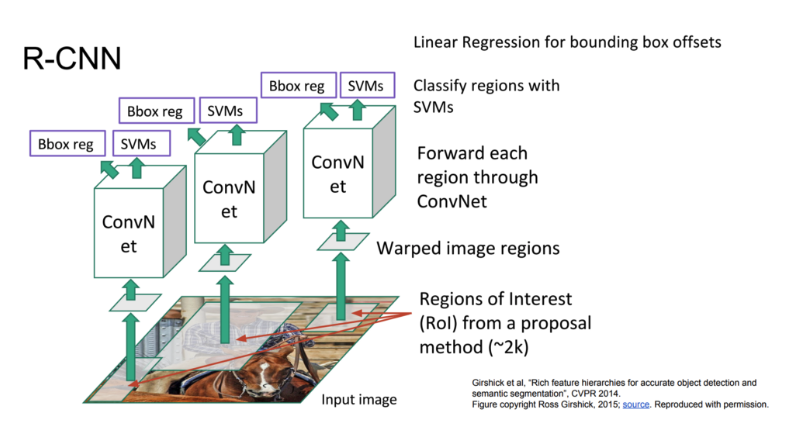

위 사진처럼 R-CNN으로 물체가 있을 법한 위치를 찾아낸다 -> 이게 Regin proposal


아무튼 두 기법의 공통분모
1) 부분 영역 탐색
2) 후보 영역 생석

### 토막 상식 : Background error

개체가 없는 배경 이미지에 개체가 있다고 판단하는 오류
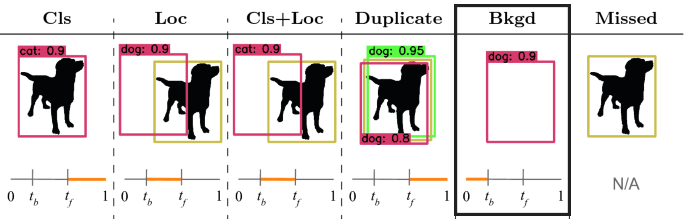

위 이미지에서 검정색 박스로 표시한게 Background Error

## 1. Introduction

기존의 Detection 모델에 대한 비판 : classifier를 재 정의하여 detector로 사용하였다.
-> classifier : 검출 알고리즘을 말함(ex, SVM)

-> 이러면 이 과정이 비판받는 이유</br>
기존 모델 : 객체 위치 제안(region proposal) -> 제안된 영역을 분류(classification)
</br>하는 방식으로 객체를 식별함
</br>이때 '분류기'에 해당하는 classifier는 단일 이미지 내의 객체를 분류하던데 사용된 모델임
</br> -> 그러니까 단일 이미지 검출기를 전체 이미지 에서 객체 검지를 하려니까 전처리가 필요하다는거

--> 이게 시간을 잡아먹는 구조라는 거임

아무튼 모든 Detection 작업은 1) Classification, 2) Objectdection 두가지 작업을 수행해야 하는데
1) Classification : 물제가 무엇인지 확인</br>
2) Objectdection : 물제의 위치정보 확인

비판의 대상으로 `R-CNN`을 선정 : 선정이유 -> 느림, 최적화 어려움

따라서 논문은 `Yolo`를 제안하였고 이건 R-CNN대비 빠르다

그럼 어떻게 빠르게 했느냐?</br>
`객체 검출 작업`을 Single regression problem(단일 회귀 문제) 로 바라보고</br>
이 단일 회귀문제의 해법을 도입해서 객체 검출을 수행함




## 2. Unified Detection

Yolo가 Single regression problem 형태로 문제를 풀이한 방법론에 대한 설명

1. Gird분할
</br> -> 입력 이미지를 `[S x S]` 크기의 그리드 셀로 나눈다
</br> -> 이때 인식하고자 하는 객체(object)의 중심점이 특정 Grid cell에 잇다 -> 
</br> 중심점이 있는 Grid Cell은 객체를 Detect하도록 `할당(responsible for)`됨
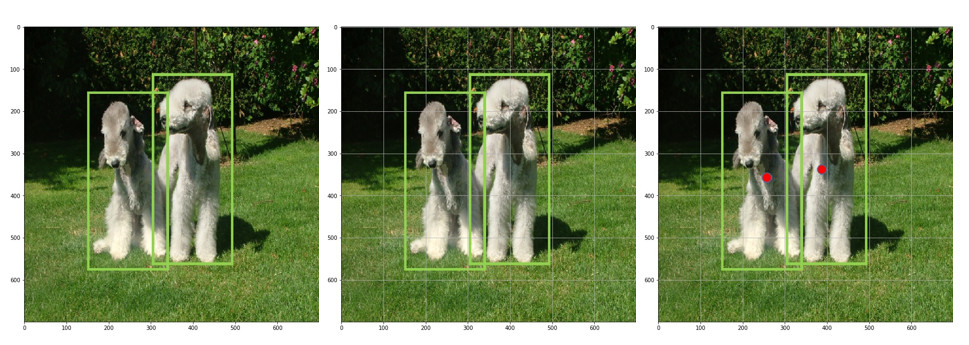

위 그림을 본다면 빨간색 점이 박힌 두개의 Grid Cell에 객체(강아지)를 할당함
</br>그리고 동시에 나머지 Grid Cell은 이 `객체 예측 과정`에 배제됨

이미지로 설명하자면 빨간색 점이 박힌 Grid Cell만 Classification 작업에 참여되고
</br> 나머지 Grid cell은 Classification을 수행하지 않음

--> 여기서 발생할 수 있는 문제점 : 빨간색 점이 박힌 지점은 강아지의 '몸통'임
</br> -> 이 몸통에 대한 정보만으로 '강아지'를 유추하는거임
</br> -> 당연히 객체 검출에 성능 한계가 발생할 수 있음
</br> -> 이걸 다음 Yolo논문에서는 '보완'함


2. 그리드 셀의 예측 -> 이걸로 바운딩 박스를 만들어 내는 작업
</br> ->  grid cell은 B개의 bounding box와 해당 bounding box에 대한 confidence score
(신뢰도)

이 신뢰도(Confidence Score)는 아래의 수식으로 계산됨

$$
confidence = Pr(object) \times IOU(pred, truth)
$$

위 신뢰도 점수가 0 : 개체가 존재하지 않는 구역임</br>
0이 아님 : 개체가 존재함 -> 이 값은 IoU와 관련된 값을 가짐

--> 따라서 각 그리드 셀이 보유한 B개의 Bounding box가 갖는 정보</br>
`[x, y, w, h, cofidence score]`

<img src="./img/06.jpg" alt="Image" style="width: 50%; height: auto;">

여기서 중요한 점 : Bounding Box는 1개의 Object에 대한 예측값을 갖는다</br>
`[x, y, w, h, cofidence score]` 이게

`[x, y, w, h, [cs_1, cs_2, cs_3.....]]` 
</br>이렇게 인식가능한 객체 당 신뢰평가를 한다는게 아니라는 거임

아무튼 `예측`을 했음 -> 딥러닝에 필요한 함수를 만들 수 있음

그러면 이제 1개의 `CS`값을 갖는 Bounding box가 있음</br>
-> 이게 Gird Cell에 B개 존재함

-> 그러면 1개의 Grid Cell에는 CS값이 B개가 존재하게 되버림
</br>이걸 학습기에 넘기면 데이터가 너무 많음
</br> '대표'가 되는 Bounding Box의 `CS`정보만 학습기로 넘김
</br> 이 '대표' Bounding box를 찾는 방법 : CS값이 가장 큰 Bounding box를 선정함


3. 전체 이미지 예측
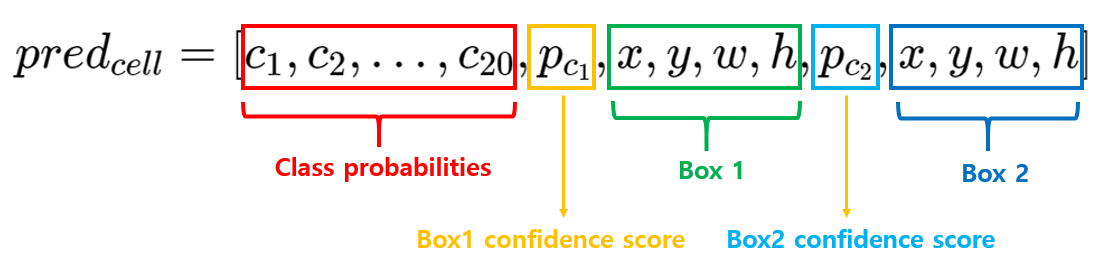

2번 과정에서 대표 Boundbox의 CS값으로 정의된 Grid Cell을 모아서 위 함수로</br>
예측 함수를 만듬 -> 이걸 학습시킴

### 2) DarkNet

앞서 Yolo의 `[SxS]`그리드셀, 그리드 셀 내 `B`개의 바운딩박스는 </br>
PASCAL VOC 데이터셋을 기준으로 했을 때 </br>
`S=7, B=2`로 설정함 그리고 PASCAL VOC의 Label개수는 20임</br>

위 파라미터로 최종 출력하고자 하는 Output Feature 크기는 </br>
[7x7x(2x5+20)] = [7x7x30]이 됨</br>
이때 `5`는 Boundbox의 [x, y, w, h cs] -> 5개 를 의미함

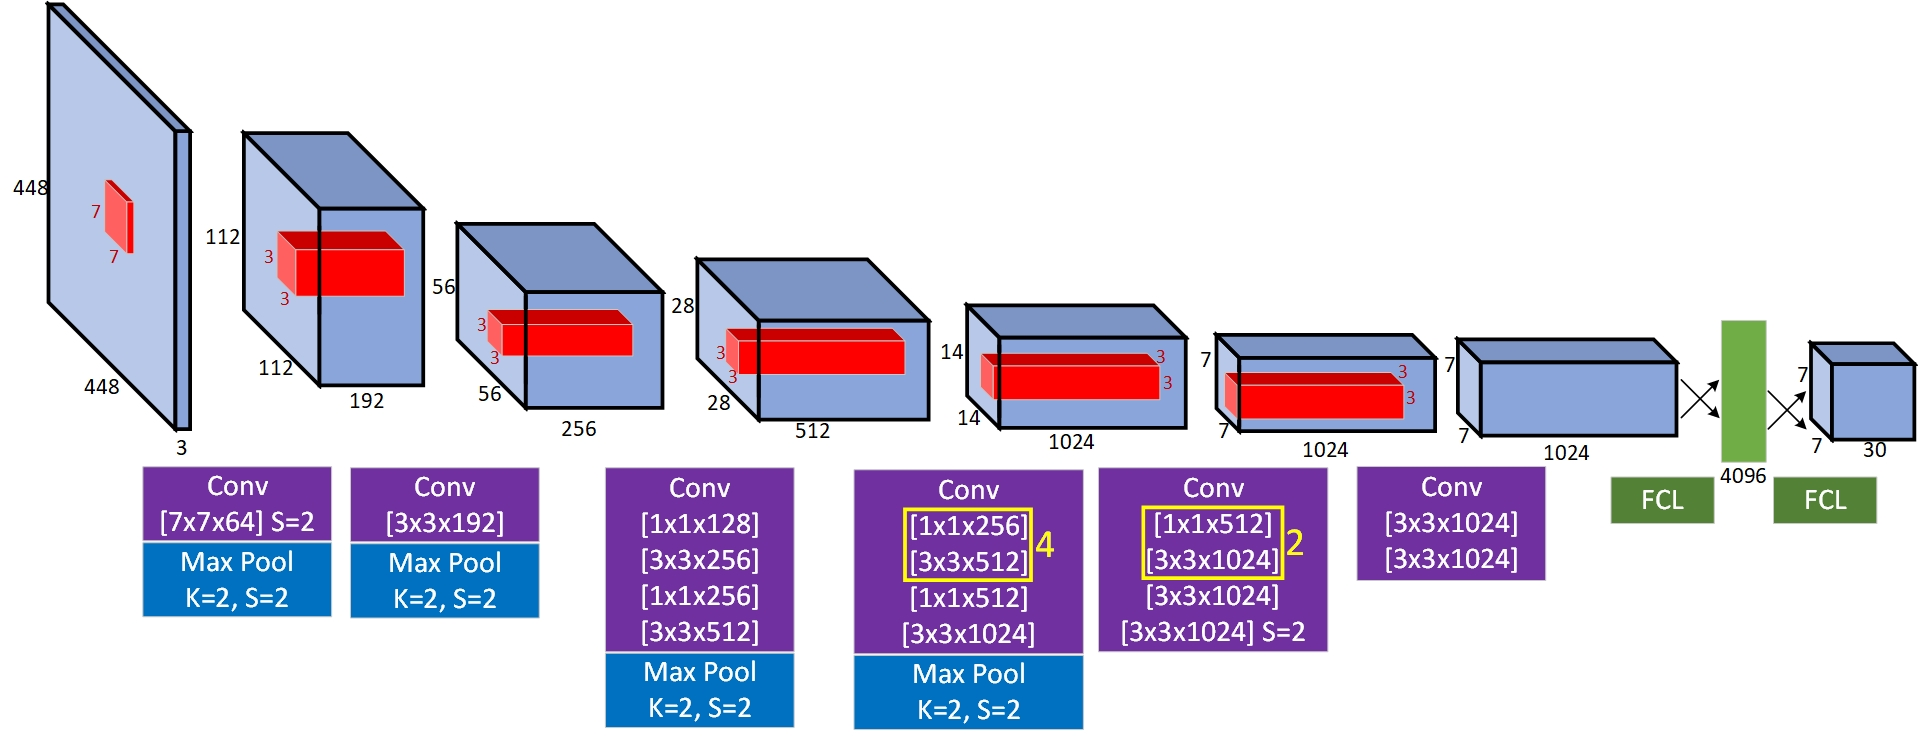

여기서 입력 이미지가 어느 블로그는 224x224x3으로 되고</br>
논문은 448x448x3으로 나옴</br>
그리고 코드 구현 예제들 보면 224x224x3임.. 하....

Yolo에 사용된 Dark Net 모델 아키텍쳐</br>
-> GoogLeNet 구조를 차용함

### 3) Loss Function
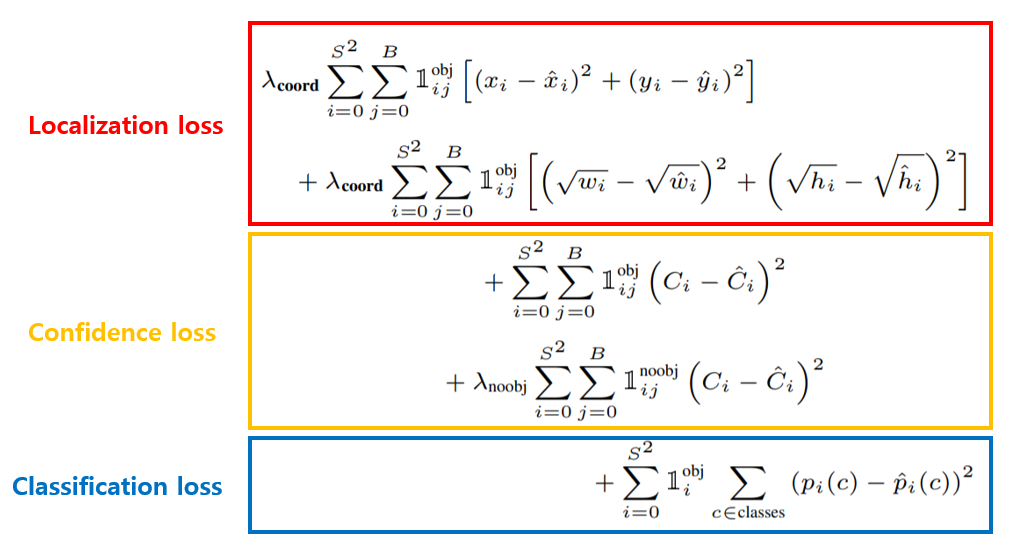

Yolo는 3개의 Loss Function을 사용함
- 위치 손실(Localization Loss) : 바운딩 박스의 일치하는 정도 -> IoU
- 신뢰도 손실(Confidence Loss) : 바운딩 박스에 객체가 포함된 정도
- 분류 손실(Classification Loss) : 인식한 개체의 종류가 맞는지

## 훈련을 위한 잡기술
- PASCAL VOC 2007, 2012 train & validation data set을 활용
- 135 epoch
- Batch size=64
- Momentum=0.9
- Decay=0.0005
- 첫 epoch에는 learning rate를 0.001에서 0.01로 천천히 상승시킴
  - 초반부터 큰 learning rate를 사용하면 Gradient explosion이 발생하기 때문에
  - ~75 epoch : learning rate = 0.01
  - ~105 epoch : learning rate = 0.001
  - ~135 epoch : learning rate = 0.0001
- Overfitting을 막기 위해 dropout과 data augmentation을 이용
  - Dropout 비율 : 0.5
  - Data augmentation : 원본 이미지의 20%까지 random scaling 및 random translation 이용


## 모델 설계하기

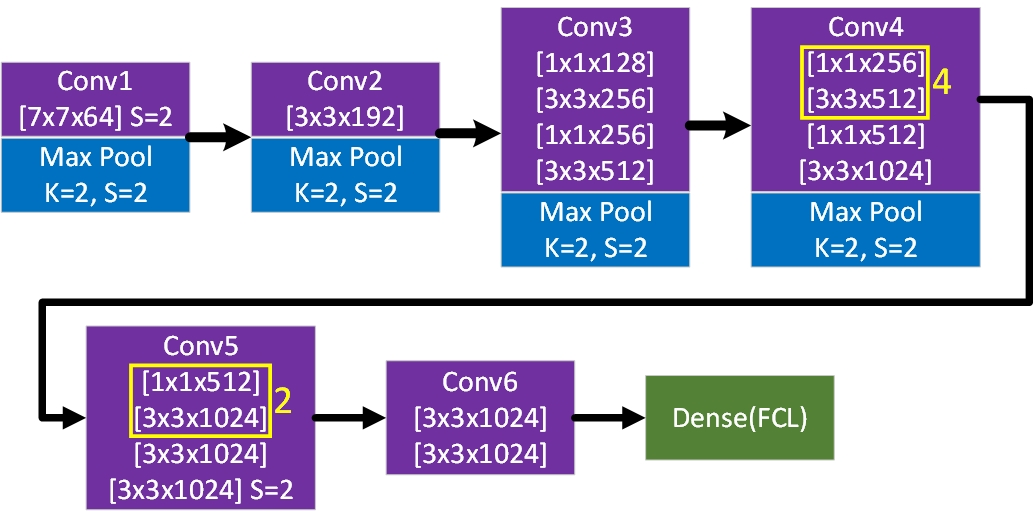
참고로 모든 Conv 뒤에는 `LiekyReLU`가 붙는다

In [4]:
import torch
import torch.nn as nn

In [6]:
class YoloConv(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(YoloConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.LeakyReLU(negative_slope=0.1)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x

In [7]:
class Yolov1(nn.Module):
    def __init__(self, S=7, B=2, num_cleasses=20):
        super(Yolov1, self).__init__()

        #Grid cell 사이즈 : S, Boundbox 개수 : b
        self.S = S
        self.B = B
        self.C = num_cleasses
        #논문애서는 클래스를 'C'계수로 씀

        self.conv1 = nn.Sequential(
            YoloConv(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv2 = nn.Sequential(
            YoloConv(64, 192, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv3 = nn.Sequential(
            YoloConv(192, 128, kernel_size=3, stride=1, padding=1),
            YoloConv(128, 256, kernel_size=3, stride=1, padding=1),
            YoloConv(256, 256, kernel_size=3, stride=1, padding=1),
            YoloConv(256, 512, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv4 = nn.Sequential(
            self._make_layer(in_ch=512, out_ch=256, blocks=4),
            YoloConv(512, 512, kernel_size=1, stride=1),
            YoloConv(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv5 = nn.Sequential(
            self._make_layer(in_ch=1024, out_ch=512, blocks=2),
            YoloConv(1024, 1024, kernel_size=3, stride=1, padding=1),
            YoloConv(1024, 1024, kernel_size=3, stride=1, padding=1),
        )

        self.conv6 = nn.Sequential(
            YoloConv(1024, 1024, kernel_size=3, stride=1, padding=1),
            YoloConv(1024, 1024, kernel_size=3, stride=1, padding=1),
        )

        self.fc_layer = None  #fc 레이어를 동적으로 설계하기
        # self.fc_layer = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(1024 * self.S * self.S, 4096),
        #     nn.LeakyReLU(0.1),
        #     nn.Linear(4096, self.S * self.S * (self.B * 5 + self.C)),
        # )

    #반복되는 conv는 여기서 처리함
    def _make_layer(self, in_ch, out_ch, blocks):
        layers = []
        for _ in range(blocks):
            layers.append(YoloConv(in_ch, out_ch, kernel_size=1, stride=1))
            layers.append(YoloConv(out_ch, in_ch, kernel_size=3, stride=1, padding=1))
        return nn.Sequential(*layers)

    def _initialize_fc_layer(self, conv_output_size, device):
        _, C, H, W = conv_output_size
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(C * H * W, 4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, self.S * self.S * (self.B * 5 + self.C)),
        )
        self.fc_layer.to(device)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)

        if self.fc_layer is None:
            self._initialize_fc_layer(x.size(), x.device)
        
        x = self.fc_layer(x)
        x = x.view(-1, self.S, self.S, self.B * 5 + self.C)
        #마지막 레이어인 [N, 7, 7, 30]을 만드는부분
        return x

In [8]:
#모델이 잘 설계되었는지 검증하는 부분
from torchsummary import summary #설계한 모델의 요약본 출력 모듈

debug_model = Yolov1()
summary(debug_model, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         LeakyReLU-2         [-1, 64, 112, 112]               0
          YoloConv-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 192, 56, 56]         110,784
         LeakyReLU-6          [-1, 192, 56, 56]               0
          YoloConv-7          [-1, 192, 56, 56]               0
         MaxPool2d-8          [-1, 192, 28, 28]               0
            Conv2d-9          [-1, 128, 28, 28]         221,312
        LeakyReLU-10          [-1, 128, 28, 28]               0
         YoloConv-11          [-1, 128, 28, 28]               0
           Conv2d-12          [-1, 256, 28, 28]         295,168
        LeakyReLU-13          [-1, 256, 28, 28]               0
         YoloConv-14          [-1, 256,

손실함수 설계

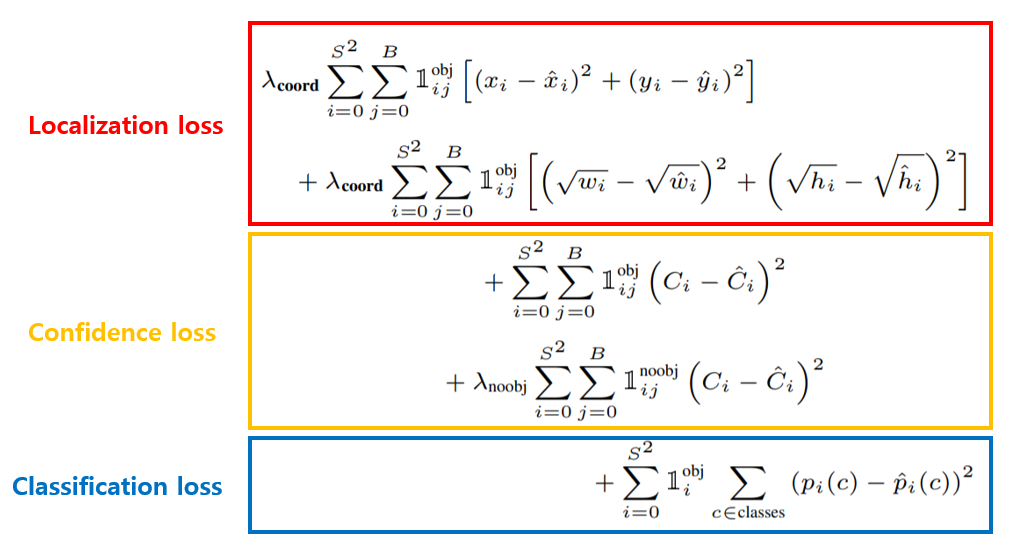

이걸 다른 블로그에서는 detech 해가면서 구하던데
chat-gpt는 그냥 torch 내에서 다 연산해버림

인간시대의 끝이 도래햇나...

In [9]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        #iou에 가중치를 부여하기 위한 값 -> 논문의 실험 계수
        self.lambda_coord = 5
        #신뢰도에 가중치를 부여하기 위한 값 -> 이것도 논문 실험계수
        self.lambda_noobj = 0.5

    #Localization Loss(IoU 구하는 부분)
    def compute_iou(self, box1, box2): 
        box1_x1 = box1[..., 0] - box1[..., 2] / 2
        box1_y1 = box1[..., 1] - box1[..., 3] / 2
        box1_x2 = box1[..., 0] + box1[..., 2] / 2
        box1_y2 = box1[..., 1] + box1[..., 3] / 2

        box2_x1 = box2[..., 0] - box2[..., 2] / 2
        box2_y1 = box2[..., 1] - box2[..., 3] / 2
        box2_x2 = box2[..., 0] + box2[..., 2] / 2
        box2_y2 = box2[..., 1] + box2[..., 3] / 2

        inter_x1 = torch.max(box1_x1, box2_x1)
        inter_y1 = torch.max(box1_y1, box2_y1)
        inter_x2 = torch.min(box1_x2, box2_x2)
        inter_y2 = torch.min(box1_y2, box2_y2)

        #area가 음수가 나오는걸 방지 -> 그래서 clamp(0)을 넣음
        inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)

        box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
        box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

        union_area = box1_area + box2_area - inter_area

        return inter_area / union_area

    def forward(self, predictions, target):

        #model이 결과로 출력한 box랑 클래스 정보를 추출해냄
        pred_boxes = predictions[..., :self.B*5].view(-1, self.S, self.S, self.B, 5)
        pred_classes = predictions[..., self.B*5:].view(-1, self.S, self.S, self.C)

        target_boxes = target[..., :self.B*5].view(-1, self.S, self.S, self.B, 5)
        target_classes = target[..., self.B*5:].view(-1, self.S, self.S, self.C)

        #그리드셀에 대한 식별 마스크 : 개체가 있음 -> coord, 없음 -> noobj
        coord_mask = target_boxes[..., 4] > 0
        noobj_mask = target_boxes[..., 4] == 0

        #신뢰도 손실값(Cofidence loss)를 계산하는 코드
        coord_loss = self.lambda_coord * (
            (pred_boxes[coord_mask][..., :2] - target_boxes[coord_mask][..., :2]) ** 2 +
            (torch.sqrt(pred_boxes[coord_mask][..., 2:4]) - torch.sqrt(target_boxes[coord_mask][..., 2:4])) ** 2
        ).sum()

        iou_scores = self.compute_iou(pred_boxes[..., :4], target_boxes[..., :4])
        pred_confidences = pred_boxes[..., 4]
        target_confidences = iou_scores * target_boxes[..., 4]

        conf_loss = (
            (pred_confidences[coord_mask] - target_confidences[coord_mask]) ** 2 +
            self.lambda_noobj * (pred_confidences[noobj_mask] - target_confidences[noobj_mask]) ** 2
        ).sum()

        class_loss = (
            (pred_classes[coord_mask] - target_classes[coord_mask]) ** 2
        ).sum()

        return coord_loss + conf_loss + class_loss

코드에 대한 설명
```python
def compute_iou(self, box1, box2): 
```
바운딩 박스 2개의 겹쳐지는 정도 -> IoU를 계산하기 위한 함수(Localization Loss)

YOLO에서는 바운딩 박스를 (x, y, w, h)의 형식으로 표현</br>
-> 여기서 x, y는 바운딩 박스의 중심 좌표이니 사각형을 그리기 위해서는</br>
-> [min_x, min_y], [max_x, max_y]를 알아내야함

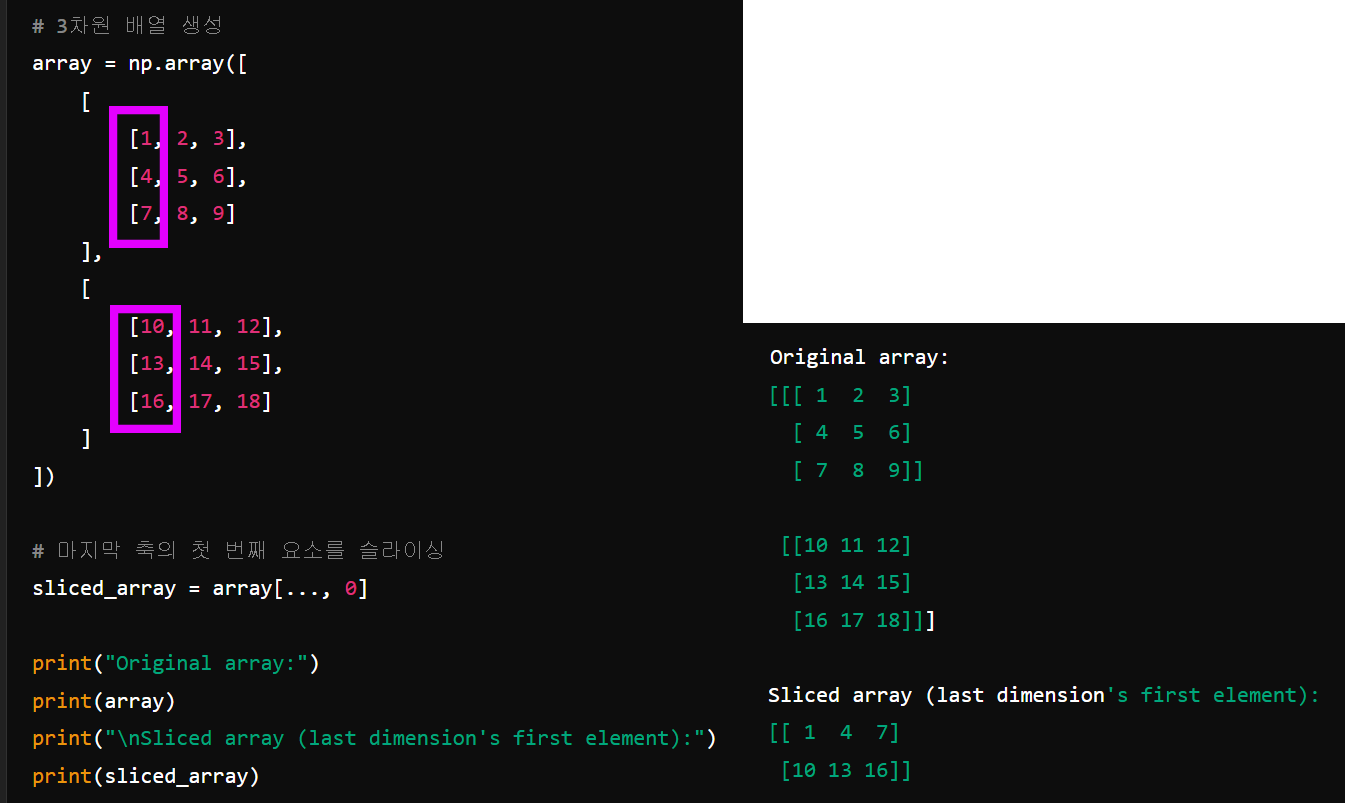


텐서 자료형으로 가져온 box1(Pred), box2(Ground_True)는
[x, y, w, h]가 연속된 것이니

`min_x = x - w / 2`   `min_y = y - h / 2`

`max_x = x + w / 2`   `max_y = y + h / 2`

를 계산한다.

```python
def forward(self, predictions, target):
``

모델의 최종 출력값이
```python
x = x.view(-1, self.S, self.S, self.B * 5 + self.C)
```
위 코드로 인해 [Batch_size, S, S, 30]</br>
-> 여기서 30은 `바운딩 박스 수(2) * (x,y,w,h.CS) + 클래스개수(20)`

따라서
```python
boxes = predictions[..., :self.B*5].view(-1, self.S, self.S, self.B, 5)
classes = predictions[..., self.B*5:].view(-1, self.S, self.S, self.C)
```
boxes는 박스 개수 * (x,y,w,h.CS) 이 차원을 끄집어 내는 것이고</br>
classes는 그 이후 20개의 클래서 정보(one hot encoding)

```python
coord_mask = target_boxes[..., 4] > 0
noobj_mask = target_boxes[..., 4] == 0
```

그리드 셀이 객체가 검출됨의 유/무를 찾는 마스크
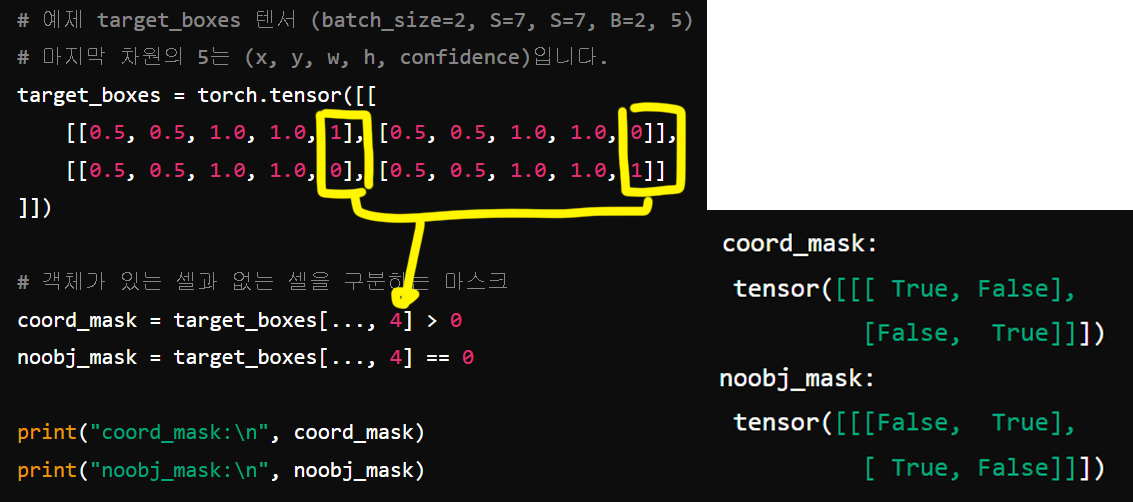

## 데이터셋 가져오기 (PASCAL VOC)

In [10]:
from torchvision import datasets, transforms

#Pascal데이터 가져오기
train_dataset = datasets.VOCDetection(root='./data/VOC',
                                        year='2007',
                                        image_set='train',
                                        download=True,
                                        transform=transforms.ToTensor())

test_dataset = datasets.VOCDetection(root='./data/VOC',
                                        year='2007',
                                        image_set='test',
                                        download=True,
                                        transform=transforms.ToTensor())



Using downloaded and verified file: ./data/VOC\VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOC\VOCtrainval_06-Nov-2007.tar to ./data/VOC
Using downloaded and verified file: ./data/VOC\VOCtest_06-Nov-2007.tar
Extracting ./data/VOC\VOCtest_06-Nov-2007.tar to ./data/VOC


In [12]:
# 고유 클래스 라벨 추출 함수
def get_unique_labels(dataset):
    unique_labels = set()
    for i in range(len(dataset)):
        annotation = dataset[i][1]
        objects = annotation['annotation']['object']
        if isinstance(objects, dict):  # 객체가 하나일 때는 dict로 반환
            objects = [objects]
        for obj in objects:
            unique_labels.add(obj['name'])
    return unique_labels

# 학습 데이터셋의 고유 라벨 개수 추출
unique_train_labels = get_unique_labels(train_dataset)
unique_test_labels = get_unique_labels(test_dataset)

# 클래스 레이블을 인덱스로 매핑
label_to_index = {label: idx for idx, label in enumerate(unique_train_labels)}

# 이미지 개수와 고유 라벨 개수 출력
num_train_images = len(train_dataset)
num_test_images = len(test_dataset)

print(f"Training Images: {num_train_images}, Unique Labels: {len(unique_train_labels)}")
print(f"Testing Images: {num_test_images}, Unique Labels: {len(unique_test_labels)}")

print(f"Unique Train Labels: {unique_train_labels}")
print(f"Unique Test Labels: {unique_test_labels}")

Training Images: 2501, Unique Labels: 20
Testing Images: 4952, Unique Labels: 20
Unique Train Labels: {'train', 'bird', 'bicycle', 'motorbike', 'bottle', 'cow', 'diningtable', 'sheep', 'dog', 'person', 'bus', 'aeroplane', 'cat', 'car', 'pottedplant', 'chair', 'horse', 'tvmonitor', 'sofa', 'boat'}
Unique Test Labels: {'train', 'bird', 'bicycle', 'motorbike', 'bottle', 'cow', 'diningtable', 'sheep', 'dog', 'person', 'bus', 'aeroplane', 'cat', 'car', 'pottedplant', 'chair', 'horse', 'tvmonitor', 'sofa', 'boat'}


In [13]:
# 데이터셋의 샘플 확인
sample_image, sample_target = train_dataset[0]
print(f"Sample image shape: {sample_image.shape}")
print(f"Sample target: {sample_target}")

Sample image shape: torch.Size([3, 333, 500])
Sample target: {'annotation': {'folder': 'VOC2007', 'filename': '000012.jpg', 'source': {'database': 'The VOC2007 Database', 'annotation': 'PASCAL VOC2007', 'image': 'flickr', 'flickrid': '207539885'}, 'owner': {'flickrid': 'KevBow', 'name': '?'}, 'size': {'width': '500', 'height': '333', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'car', 'pose': 'Rear', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}}


논문에서 사용한 데이터 증강기법
</br></br>
Random Scalling</br>
Random Translation</br>
Random Flipping</br>
Color Jittering</br>

In [14]:
from torch.utils.data.dataloader import default_collate
from PIL import Image
import numpy as np

train_transformation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((448, 448)),  # 고정된 크기로 이미지 조정
    transforms.ToTensor(),
])

test_transformation = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
])

#VOC 데이터셋은 이미지 변환이 잘 이뤄지지 않음 -> 별도의 함수로 더 강력하게 이미지 맞추기
# train_dataset.transform = train_transformation
# test_dataset.transform = test_transformation

In [32]:
def get_unique_labels(dataset):
    unique_labels = set()
    for i in range(len(dataset)):
        annotation = dataset[i][1]
        if 'annotation' not in annotation:
            continue
        objects = annotation['annotation']['object']
        if isinstance(objects, dict):  # 객체가 하나일 때는 dict로 반환
            objects = [objects]
        for obj in objects:
            unique_labels.add(obj['name'])
    return unique_labels


def extract_boxes_and_labels(annotation):
    boxes = []
    labels = []
    if 'annotation' not in annotation:
        return boxes, labels
    objects = annotation['annotation']['object']
    if isinstance(objects, dict):  # 객체가 하나일 때는 dict로 반환
        objects = [objects]
    for obj in objects:
        bbox = obj['bndbox']
        xmin = int(bbox['xmin'])
        ymin = int(bbox['ymin'])
        xmax = int(bbox['xmax'])
        ymax = int(bbox['ymax'])
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_to_index[obj['name']])  # 클래스 이름을 인덱스로 변환
    return boxes, labels


def collate_fn(batch):
    images, targets = zip(*batch)
    images = [Image.fromarray(img.mul(255).byte().numpy().transpose(1, 2, 0)) if isinstance(img, torch.Tensor) else img for img in images]
    images = [train_transformation(img) for img in images]

    # targets를 딕셔너리에서 텐서로 변환
    processed_images = []
    processed_targets = []
    for img, t in zip(images, targets):
        annotation = t.get('annotation', None)
        if annotation is None:
            continue
        boxes, labels = extract_boxes_and_labels(annotation)
        if len(boxes) == 0:
            continue
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)  # 레이블을 인덱스로 변환
        target = torch.cat([boxes, labels.unsqueeze(-1)], dim=-1)
        processed_images.append(img)
        processed_targets.append(target)

    if len(processed_images) == 0 or len(processed_targets) == 0:
        return [], []

    return default_collate(processed_images), default_collate(processed_targets)

In [33]:
BATCH_SIZE = 8

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False,
                                          collate_fn=collate_fn)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# CUDA가 사용 가능한 경우, 추가 정보 출력
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Capability: {torch.cuda.get_device_capability(0)}")
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / (1024 ** 3):.2f} GB")  # GB 단위로 변환
    print(f"Number of GPUs: {torch.cuda.device_count()}")

cuda
GPU Name: NVIDIA GeForce RTX 4090 Laptop GPU
GPU Capability: (8, 9)
Total Memory: 15.99 GB
Number of GPUs: 1


In [18]:
model = Yolov1()
model.to(device)
summary(model, input_size=(3, 448, 448), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,472
         LeakyReLU-2         [-1, 64, 224, 224]               0
          YoloConv-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 192, 112, 112]         110,784
         LeakyReLU-6        [-1, 192, 112, 112]               0
          YoloConv-7        [-1, 192, 112, 112]               0
         MaxPool2d-8          [-1, 192, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]         221,312
        LeakyReLU-10          [-1, 128, 56, 56]               0
         YoloConv-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         295,168
        LeakyReLU-13          [-1, 256, 56, 56]               0
         YoloConv-14          [-1, 256,

## 옵티마이저, 하이퍼 파라미터

논문
Optimizer: Stochastic Gradient Descent (SGD)</br>
Learning Rate: 0.001 초기값, 이후 단계적으로 감소</br>
Momentum: 0.9   Weight Decay: 0.0005</br>
Learning Rate Scheduler: 일정 에폭마다 학습률을 감소시킴</br>

```python
criterion = YoloLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
# Learning Rate Scheduler 정의
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
```

In [19]:
from torch import optim

#손실함수
criterion = YoloLoss().to(device)
# Adam 옵티마이저 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Learning rate 스케줄러 정의 (여기서는 CosineAnnealingLR을 사용)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


## 훈련/검증 함수 만들기

In [38]:
epoch_step = 10

from tqdm import tqdm  # 훈련 진행상황 체크

def model_train(model, data_loader, loss_fn, optimizer_fn, scheduler_fn, processing_device, epoch):
    model.train()  # 모델을 훈련 모드로 설정

    global epoch_step

    # loss와 accuracy를 계산하기 위한 임시 변수를 생성
    run_size, run_loss, correct = 0, 0, 0

    # 특정 에폭일 때만 tqdm 진행상황 바 생성
    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        progress_bar = tqdm(data_loader)
    else:
        progress_bar = data_loader

    for batch in progress_bar:
        if not batch[0] or not batch[1]:
            continue
        image, labels = batch
        # 입력된 데이터를 먼저 GPU로 이전하기
        image = image.to(processing_device)
        labels = labels.to(processing_device)

        # 전사 과정 수행
        output = model(image)
        loss = loss_fn(output, labels)
        
        # 손실 함수 값 확인
        print(f'Loss: {loss.item()}')

        # backward 과정 수행
        optimizer_fn.zero_grad()
        loss.backward()
        optimizer_fn.step()

        # 학습률 스케줄러 스텝을 optimizer step 이후로 이동
        scheduler_fn.step()

        # argmax = 주어진 차원에서 가장 큰 값을 가지는 요소의 인덱스를 반환
        pred = output.argmax(dim=1)  # 예측값의 idx 출력

        # 예측한 클래스와 실제 클래스를 비교하여 정확도 계산
        correct += pred.eq(labels[..., -1]).sum().item()

        # 현재까지 수행한 loss값을 얻어냄
        run_loss += loss.item() * image.size(0)
        run_size += image.size(0)

        # tqdm bar에 추가 정보 기입
        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            progress_bar.set_description('[Training] loss: ' +
                                         f'{run_loss / run_size:.4f}, accuracy: ' +
                                         f'{correct / run_size:.4f}')
    
    avg_accuracy = correct / len(data_loader.dataset)
    avg_loss = run_loss / len(data_loader.dataset)

    return avg_loss, avg_accuracy

def model_evaluate(model, data_loader, loss_fn, processing_device, epoch):
    model.eval()  # 모델을 평가 모드로 전환 -> dropout 기능이 꺼진다
    # batchnormalizetion 기능이 꺼진다.
    global epoch_step

    # gradient 업데이트를 방지해주자
    with torch.no_grad():

        # 여기서도 loss, accuracy 계산을 위한 임시 변수 선언
        run_loss, correct = 0, 0

        # 특정 에폭일 때만 tqdm 진행상황 바 생성
        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            progress_bar = tqdm(data_loader)
        else:
            progress_bar = data_loader

        for batch in progress_bar:
            if not batch[0] or not batch[1]:
                continue
            image, labels = batch
            # 입력된 데이터를 먼저 GPU로 이전하기
            image = image.to(processing_device)
            labels = labels.to(processing_device)  # 타겟 데이터를 GPU로 이동

            # 평가 결과를 도출하자
            output = model(image)
            pred = output.argmax(dim=1)  # 예측값의 idx 출력

            # 모델의 평가 결과 도출 부분
            # 배치의 실제 크기에 맞추어 정확도와 손실을 계산
            # 예측한 클래스와 실제 클래스를 비교하여 정확도 계산
            correct += pred.eq(labels[..., -1]).sum().item()
            run_loss += loss_fn(output, labels).item() * image.size(0)

        accuracy = correct / len(data_loader.dataset)
        loss = run_loss / len(data_loader.dataset)

        return loss, accuracy


In [39]:
# 학습과 검증 손실 및 정확도를 저장할 리스트
his_loss, his_accuracy = [], []
num_epoch = 1

for epoch in range(num_epoch):
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, 
                                        criterion, optimizer, scheduler, 
                                        device, epoch)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    test_loss, test_acc = model_evaluate(model, test_loader, 
                                         criterion, device, epoch)

    # 손실과 정확도를 리스트에 저장
    his_loss.append((train_loss, test_loss))
    his_accuracy.append((train_acc, test_acc))

    #epoch가 특정 배수일 때만 출력하기
    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        print(f"epoch {epoch+1:03d}, Training loss: " + 
              f"{train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

100%|██████████| 619/619 [02:58<00:00,  3.48it/s]

epoch 001, Training loss: 0.0000, Training accuracy: 0.0000
Test loss: 0.0000, Test accuracy: 0.0000


# GG